Обучите простую модель предсказания цены акций. Используйте рассмотренные на лекции алгоритмы предсказания рядов (не менее двух,например, модель Хольта-Уинтерса и SARIMA). Можно использовать и более сложные алгоритмы предсказания рядов


1. Найдите данные о цене любого биржевого актива

    Данные должны содержать значение цены актива как минимум за каждый день и длительностю как минимум за год.

    Найти данные можно на kaggle или использовать FAANG датасет из 1-й лабораторной


2. Предобработайте данные

    Временной ряд сложно предсказывать по дням. Сделайте ряд по неделям или месяцам

    Удалите из ряда тренд, если он есть. Используйте другие рассмотренные на лекции приёмы


3. Обучите модель

    Обучите модели на 80% временного ряда

    Предскажите оставшиеся 20% (как минимум 3 точки) ряда с помощью моделей

    Отобразите на графике предсказание моделей и истинные данные


4. Посчитайте метрику

    Метрика должна отражать разницу между предсказанными и истинными данными. Можно выбрать меру MAPE, можно предложить свою

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from scipy.optimize import minimize
from pmdarima.arima import auto_arima

data = pd.read_csv("data/Google_Historical_StockPrice2.csv")
# Сразу группируем данные по месяцам, приведя дату к правильному виду
data["Date"] = pd.to_datetime(data["Date"], format="%Y.%m.%d %H:%M:%S")
data = data.sort_values(by="Date")
data = data.set_index("Date")
data = data.groupby(pd.Grouper(freq="W")).mean()

Проверим наличие тренда и сезонности

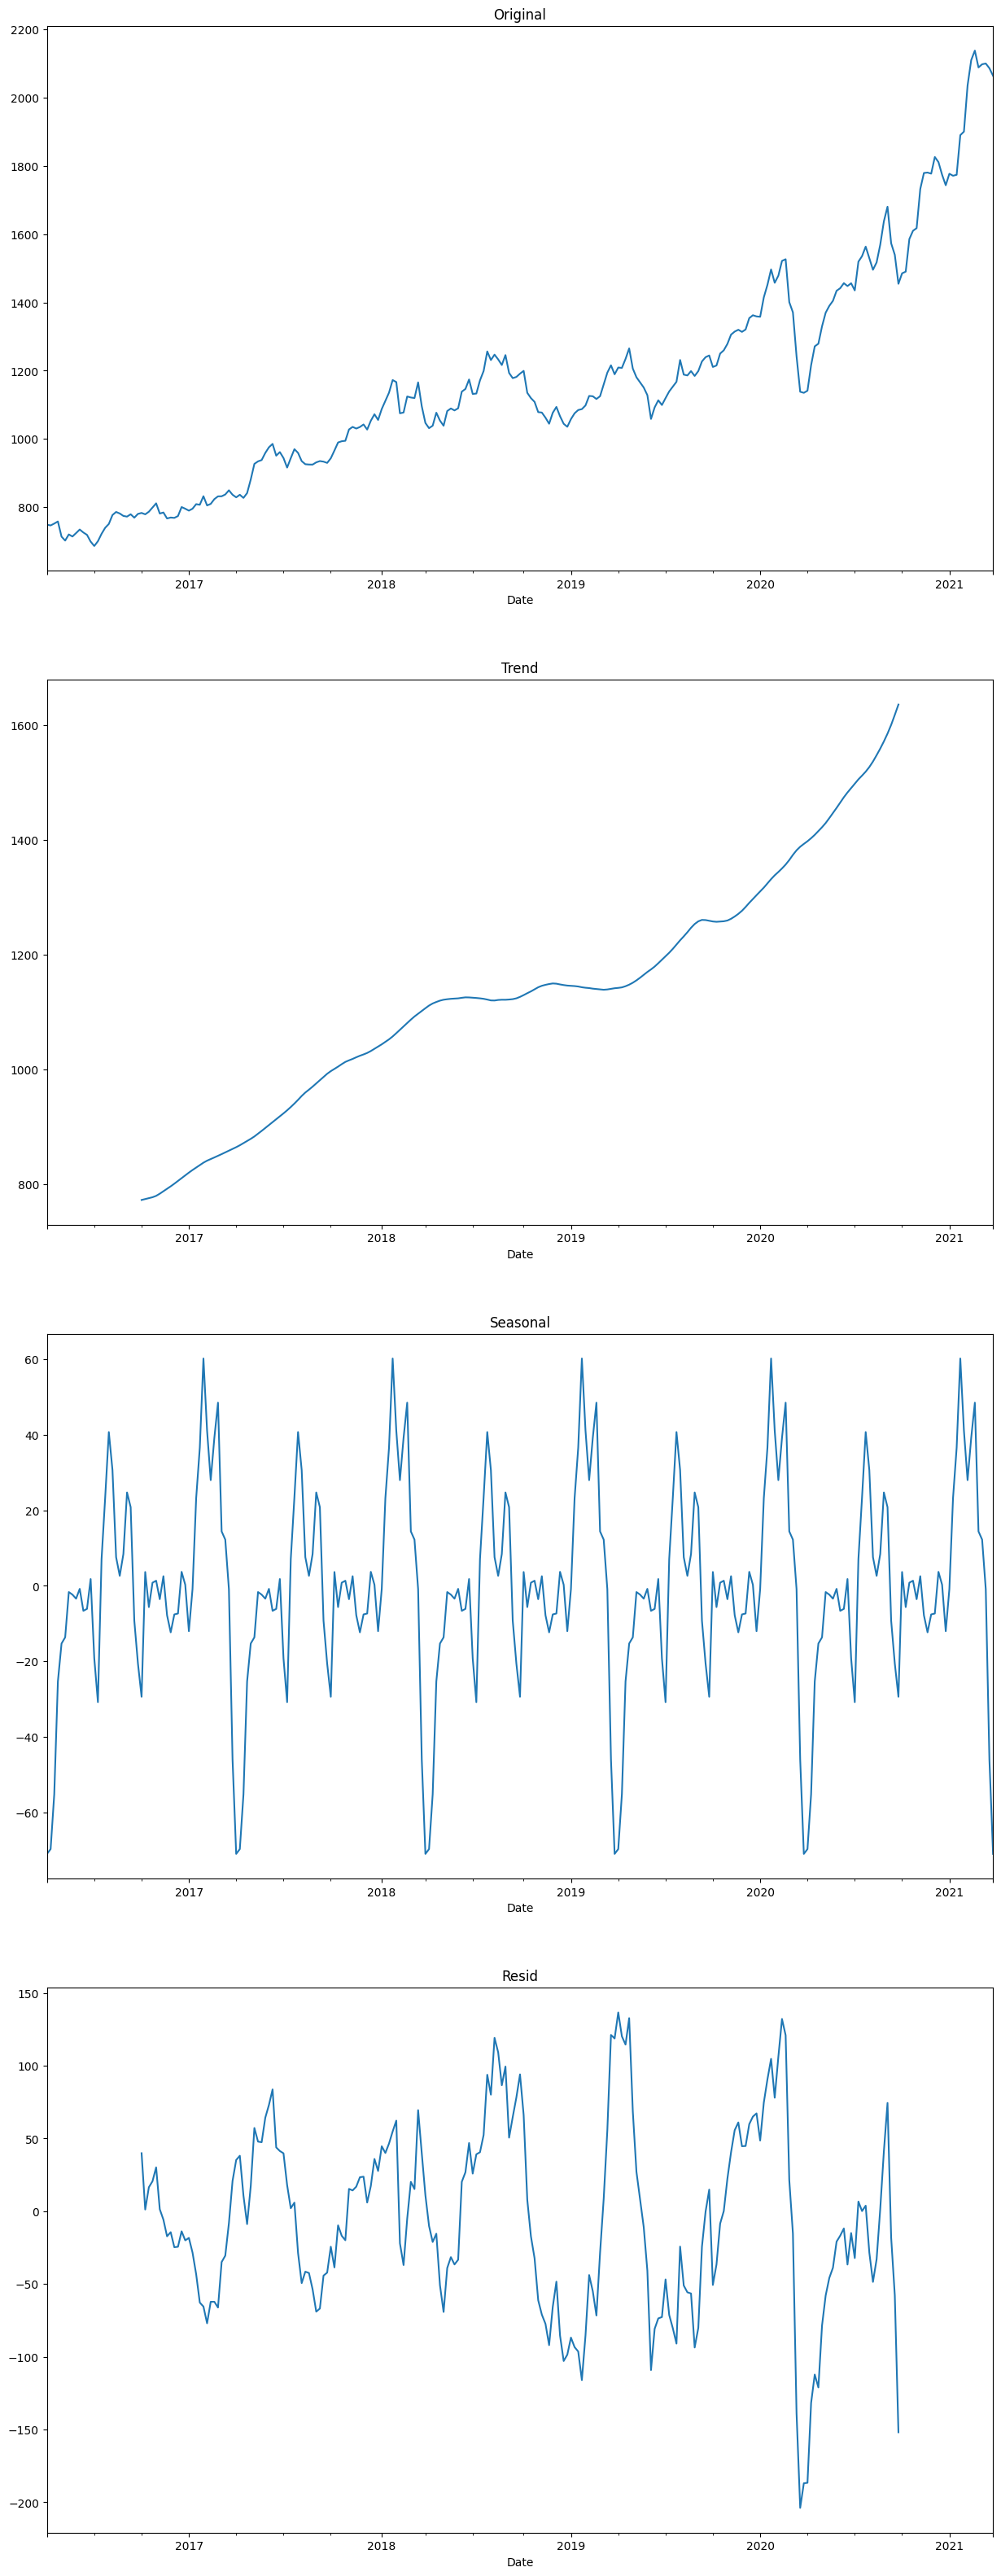

In [2]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 40))
decompose = seasonal_decompose(data.High)

ax[0].set_title("Original")
ax[1].set_title("Trend")
ax[2].set_title("Seasonal")
ax[3].set_title("Resid")

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3])
plt.show()

В целом видна четко выраженная сезонность. Однако убедимся в отсутствии стационарности с помощью теста Дики-Фуллера

In [3]:
def p_value_info(data):
    p_value = round(adfuller(data)[1], 4)
    print(f"Полученный уровень значимости (p-value): {p_value}")
    print("Ряд нестационарен" if p_value > 0.05 else "Ряд стационарен")

In [4]:
p_value_info(data.High)

Полученный уровень значимости (p-value): 0.9823
Ряд нестационарен


Избавимся от тренда и сезонности путем логарифмирования данных

P.S. на самом деле это сделал seasonal_decompose и можно использовать decompose.resid. Но мы ведь выше этого?)

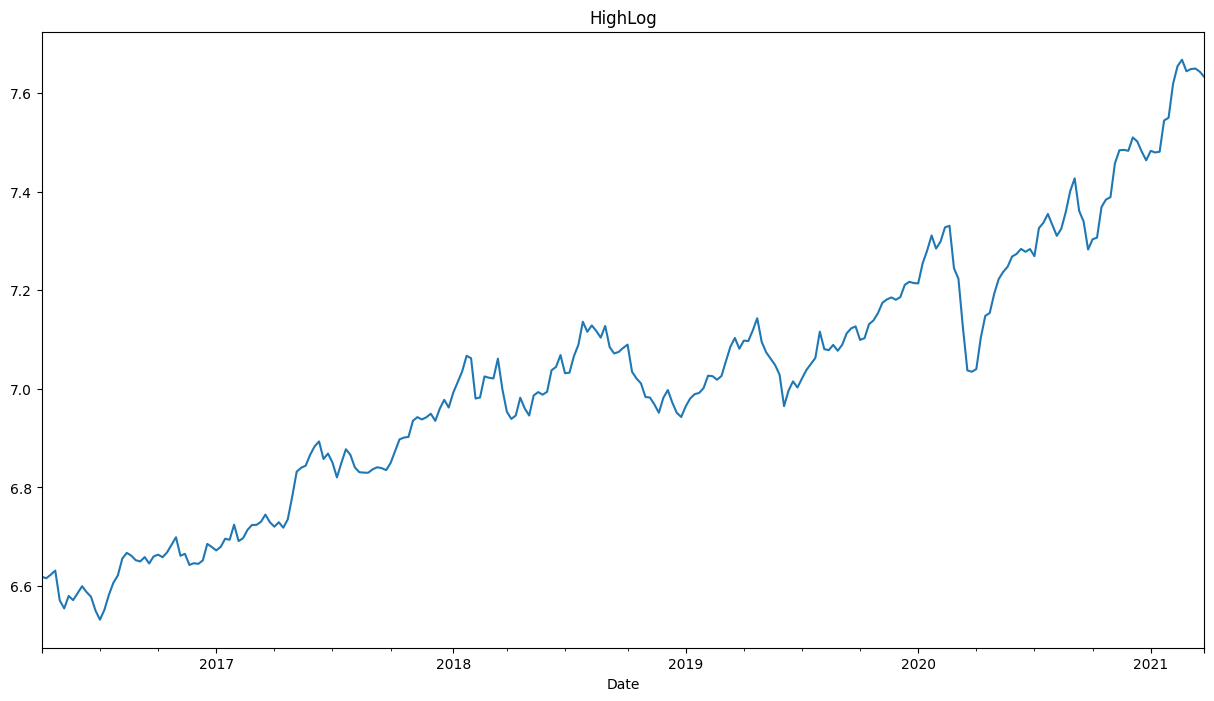

In [5]:
data["HighLog"] = np.log(data.High)

plt.figure(figsize=(15, 8))
plt.title("HighLog")
data.HighLog.plot()
plt.show()

Продифференцируем временной ряд и проверим его на стационарность

Полученный уровень значимости (p-value): 0.0
Ряд стационарен


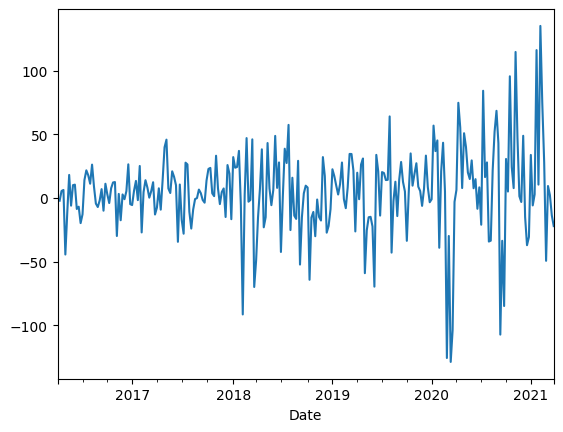

In [6]:
data["HighLogDiff"] = data.High.diff()
p_value_info(data.HighLogDiff[1:])
data.HighLogDiff.plot()
plt.show()

Строим коррелограммы

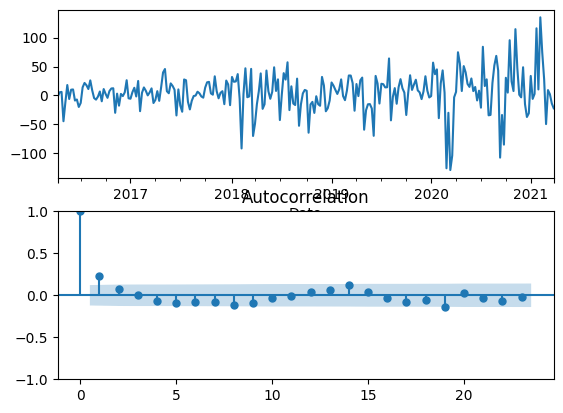

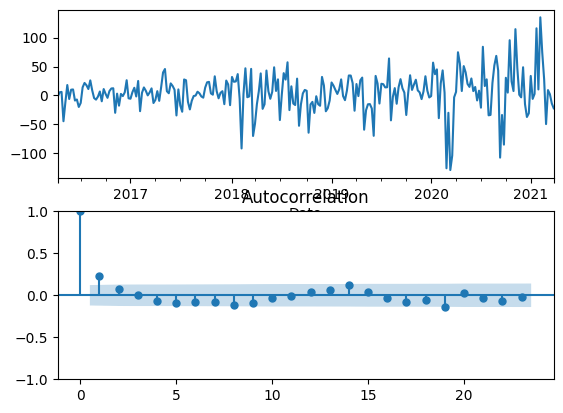

In [7]:
ax = plt.subplot(211)
data.HighLogDiff[1:].plot(ax=ax)

ax = plt.subplot(212)
plot_acf(data.HighLogDiff[1:], lags=23, ax=ax)
plt.show()

## Модель HolterWinter

In [8]:
def HolterWinter(data, L, alpha, beta, gamma, m):
    # находим изначальные сезонности
    season_num = int(len(data) / L)  # кол-во cезонов
    seasonalities = {}  # сами сезонности
    season_avgs = []  # их среднее
    # находим сезонное среднее
    season_avgs = [sum(data[L * i: L * i + L]) / float(L) for i in range(season_num)]
    # находим начальные значения cезонности
    for i in range(L):
        avg_over_summ = 0.0
        for j in range(season_num):
            avg_over_summ += data[L * j + i] - season_avgs[j]
        seasonalities[i] = avg_over_summ / season_num
    # инициализируем массивы результирующих прогнозов, сгалженных, сезонных и трендовых (нужны в формулах на пред шагах)
    result = []
    smooth = []
    season = []
    trend = []
    # пройдемся по всем данным + длинна предсказания m
    for i in range(len(data) + m):
        # инициализируем значения шага 0
        if i == 0:
            smooth_val = data[0]  # первое значения сглаживания
            trend_val = sum([(float(data[i + L] - data[i]) / L) for i in range(L)]) / L  # первое значения тренда
            result.append(data[0])  # первая точка данных совпадает с исходной
            smooth.append(smooth_val)  # добавляем первое значение сглаживание в массив трендов
            trend.append(trend_val)  # добавляем первое значение тренда в массив трендов
            season.append(seasonalities[i % L])  # см mod L
            continue  # завершаем первый шаг
        # выполняем прогноз, если вышли за пределы данных
        if i >= len(data):
            # текущее прогнозируемое значение t+1, t+2, ... (текущее m)
            curr_m = i - len(data) + 1
            result.append((smooth_val + curr_m * trend_val) + seasonalities[i % L])
        else:  # основной цикл вычисления параметров
            last_smooth_val = smooth_val
            smooth_val = alpha * (data[i] - seasonalities[i % L]) + (1 - alpha) * (
                    smooth_val + trend_val)  # обновляем lx
            trend_val = beta * (smooth_val - last_smooth_val) + trend_val * (1 - beta)  # обновляем bx
            seasonalities[i % L] = gamma * (data[i] - smooth_val) + (1 - gamma) * seasonalities[i % L]  # обновляем sx
            result.append(smooth_val + trend_val + seasonalities[i % L])  # записываем результат

            smooth.append(smooth_val)
            trend.append(trend_val)
            season.append(seasonalities[i % L])
    return result[-m:]


def predict(train, m, alpha, beta, gamma):
    return HolterWinter(train, L=100, alpha=alpha, beta=beta, gamma=gamma, m=m)


def check(x):
    alpha, beta, gamma = x
    preds = predict(train, len(test), alpha, beta, gamma)
    return mean_squared_error(preds[:index], test)

Бьем данные в соотношении 80 на 20 (тренировочные данные и тестовые)

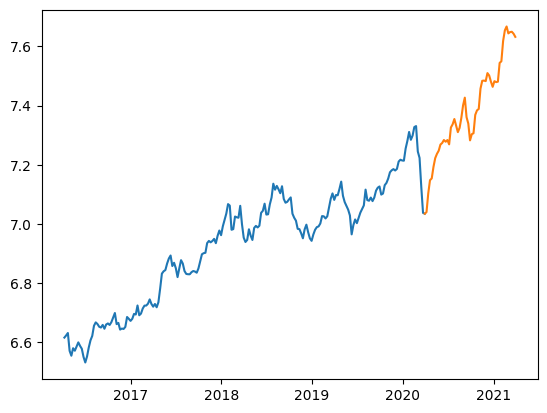

In [9]:
index = int(0.80 * len(data.HighLog))

train, test = data.HighLog[1:index + 1], data.HighLog[index:]
plt.plot(train)
plt.plot(test)
plt.show()

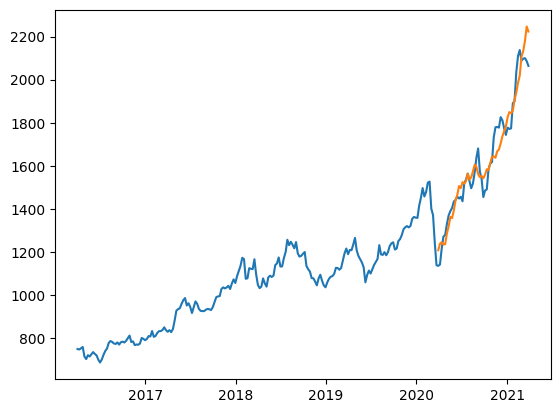

In [10]:
optimizer = minimize(check, np.array([0, 0, 0]), method="l-bfgs-b", bounds=((0, 1), (0, 1), (0, 1)))

alpha, beta, gamma = optimizer.x
predicted1 = pd.Series(predict(train, len(test), alpha, beta, gamma), index=test.index)

plt.plot(data.High)
plt.plot(np.exp(predicted1))
plt.show()

## Модель ARIMA

In [11]:
model = auto_arima(train, start_p=1, start_q=1, test="adf", max_p=2, max_q=1, m=100,
                   start_P=0, max_P=1, max_Q=1, d=0, D=1, seasonal=True, error_action="ignore", supress_warnings=True,
                   trace=True)

model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[100] intercept   : AIC=inf, Time=54.52 sec
 ARIMA(0,0,0)(0,1,0)[100] intercept   : AIC=-186.608, Time=5.72 sec
 ARIMA(1,0,0)(1,1,0)[100] intercept   : AIC=-414.979, Time=61.00 sec
 ARIMA(0,0,1)(0,1,1)[100] intercept   : AIC=inf, Time=100.98 sec
 ARIMA(0,0,0)(0,1,0)[100]             : AIC=56.035, Time=1.57 sec
 ARIMA(1,0,0)(0,1,0)[100] intercept   : AIC=-414.120, Time=13.28 sec
 ARIMA(1,0,0)(1,1,1)[100] intercept   : AIC=-412.983, Time=107.16 sec
 ARIMA(1,0,0)(0,1,1)[100] intercept   : AIC=-414.988, Time=57.19 sec
 ARIMA(0,0,0)(0,1,1)[100] intercept   : AIC=inf, Time=44.03 sec
 ARIMA(2,0,0)(0,1,1)[100] intercept   : AIC=inf, Time=170.42 sec
 ARIMA(2,0,1)(0,1,1)[100] intercept   : AIC=-413.253, Time=100.57 sec
 ARIMA(1,0,0)(0,1,1)[100]             : AIC=-412.897, Time=84.20 sec

Best model:  ARIMA(1,0,0)(0,1,1)[100] intercept
Total fit time: 800.798 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                                     y   No. Observations:                  208
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 100)   Log Likelihood                 211.494
Date:                               Tue, 18 Oct 2022   AIC                           -414.988
Time:                                       18:28:45   BIC                           -404.259
Sample:                                   04-10-2016   HQIC                          -410.638
                                        - 03-29-2020                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0123      0.011      1.117      0.264      -0.009       0.034
ar.L1          0.9563      0.038     25.075      0.000       0.882       1.031
ma.S.L100     -0.3600      0.270     -1.335      0.182      -0.889       0.169
sigma2         0.0010      0.000      6.053      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   2.17   Jarque-Bera (JB):                24.42
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               1.73   Skew:                            -0.31
Prob(H) (two-sided):                  0.11   Kurtosis:                         5.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

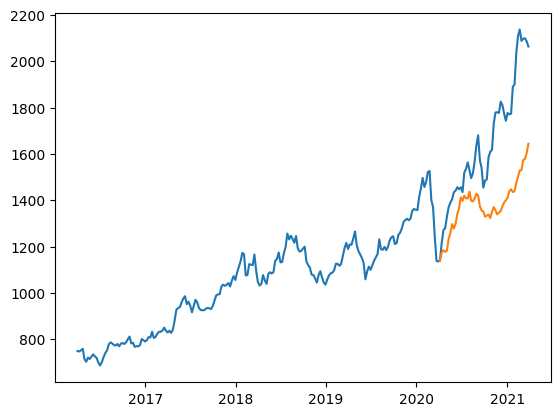

In [15]:
fitted, confint = model.predict(n_periods=len(test), return_conf_int=True)
predicted2 = pd.Series(fitted, index=test.index)

plt.plot(data.High)
plt.plot(np.exp(predicted2))
plt.show()

## Расчет MAPE

In [16]:
print(mean_absolute_percentage_error(np.exp(predicted1.notna()), data.High.notna()[index:]))

0.6323


In [17]:
print(mean_absolute_percentage_error(np.exp(predicted2.notna()), data.High.notna()[index:]))

0.6206
